In [19]:
import imageio
import IPython
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.networks import sequential
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from IPython.display import Video
from tf_agents.metrics import tf_metrics
from tf_agents.eval.metric_utils import log_metrics

In [17]:
def create_policy_eval_video(policy, env, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = env.reset()
      video.append_data(tf.squeeze(env.render()).numpy())
      steps = 0
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = env.step(action_step.action)
        video.append_data(tf.squeeze(env.render()).numpy())
        steps = steps + 1
      print(f"ep: {steps}")
  return Video(filename)

In [3]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [70]:
def graph_returns(returns, timesteps):
    plt.plot(timesteps, returns)
    plt.ylabel('Average Return')
    plt.xlabel('Iterations')

In [5]:
env_name = "LunarLander-v2"
train_py_env = suite_gym.load(env_name)
train_env = tf_py_environment.TFPyEnvironment(train_py_env)

eval_py_env = suite_gym.load(env_name)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [60]:
fc_layer_params = (48, 24)
learning_rate = 0.001

action_tensor_spec = tensor_spec.from_spec(train_env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu)

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None)
q_net = sequential.Sequential(dense_layers + [q_values_layer])

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

epsilon_fn = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=0.5, end_learning_rate=0.01, decay_steps=25000)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    target_update_period=50,
    gamma=0.95,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter,
    epsilon_greedy=lambda: epsilon_fn(train_step_counter))

agent.initialize()

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

In [61]:
replay_buffer_capacity = 10000 # @param {type:"integer"}
batch_size = 64  # @param {type:"integer"}

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2,
    single_deterministic_pass=False).prefetch(3)

iterator = iter(dataset)

In [64]:
def train(agent, train_env, dataset_iterator, returns = [], timesteps = [], collect_steps_per_iteration=20, num_iterations=25000, eval_interval=200):
    
    metrics = [
        tf_metrics.NumberOfEpisodes(),
        tf_metrics.EnvironmentSteps(),
        tf_metrics.AverageReturnMetric(buffer_size=10),
        tf_metrics.AverageReturnMetric(buffer_size=30),
        tf_metrics.AverageReturnMetric(buffer_size=100),
        tf_metrics.AverageEpisodeLengthMetric()
    ]

    # Reset the environment.
    time_step = train_env.reset()

    # Create a driver to collect experience.
    collect_driver = dynamic_step_driver.DynamicStepDriver(
        train_env,
        agent.collect_policy,
        observers=[replay_buffer.add_batch] + metrics,
        num_steps=collect_steps_per_iteration)

    for i in range(num_iterations):
        # Collect a few steps and save to the replay buffer.
        time_step, _ = collect_driver.run(time_step)

        # Sample a batch of data from the buffer and update the agent's network.
        experience, unused_info = next(dataset_iterator)
        train_loss = agent.train(experience).loss

        step = agent.train_step_counter.numpy()

        if step % eval_interval == 0:
            print(f"E: {metrics[0].result()}, I: {i}, R10: {metrics[2].result():.2f}, E30: {metrics[3].result():.2f}, R100: {metrics[4].result():.2f}, AEL: {metrics[5].result()}")
            returns.append(metrics[3].result().numpy())
            timesteps.append(train_step_counter.numpy())

In [65]:
training_returns = []
training_timesteps = []
# Reset the train step.
agent.train_step_counter.assign(0)

<tf.Variable 'UnreadVariable' shape=() dtype=int32, numpy=0>

In [66]:
%%time

train(agent, train_env, iterator, training_returns, training_timesteps)

E: 38, I: 199, R10: -184.85, E30: -202.48, R100: -205.13, AEL: 116.80000305175781
E: 69, I: 399, R10: -182.16, E30: -245.57, R100: -218.70, AEL: 108.5999984741211
E: 94, I: 599, R10: -211.54, E30: -178.83, R100: -210.84, AEL: 152.6999969482422
E: 108, I: 799, R10: -157.06, E30: -165.93, R100: -198.69, AEL: 216.6999969482422
E: 121, I: 999, R10: -160.84, E30: -144.16, R100: -199.37, AEL: 290.20001220703125
E: 142, I: 1199, R10: -102.71, E30: -138.66, R100: -176.55, AEL: 170.39999389648438
E: 156, I: 1399, R10: -157.06, E30: -142.32, R100: -154.41, AEL: 225.8000030517578
E: 169, I: 1599, R10: -178.97, E30: -159.38, R100: -156.45, AEL: 354.79998779296875
E: 184, I: 1799, R10: -167.89, E30: -166.17, R100: -153.23, AEL: 291.0
E: 202, I: 1999, R10: -136.32, E30: -166.99, R100: -153.22, AEL: 188.5
E: 218, I: 2199, R10: -156.78, E30: -157.85, R100: -155.61, AEL: 273.70001220703125
E: 230, I: 2399, R10: -83.66, E30: -120.38, R100: -148.00, AEL: 355.3999938964844
E: 246, I: 2599, R10: -124.18, E

In [72]:
len(training_returns)

125

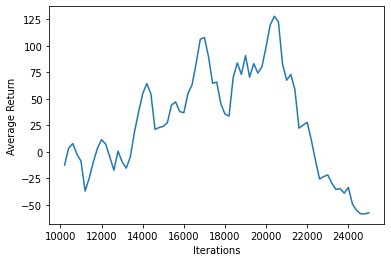

In [73]:
graph_returns(training_returns[50:], training_timesteps[50:])

In [74]:
create_policy_eval_video(agent.policy, eval_env, "lunar-lander")

[swscaler @ 0x7f8cc00b8000] Warning: data is not aligned! This can lead to a speed loss


ep: 477
ep: 1000
ep: 1000
ep: 1000
ep: 627
